create simple model draft to get outlet embeddings 

In [17]:
import pandas as pd
import numpy as np
import torch 
from torchmetrics.functional.classification import f1_score
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm 
import random
import wandb 
import pickle
from sklearn.model_selection import train_test_split

In [31]:
TRAIN_PROP = .7 
VALID_PROP = .2
TEST_PROP = .1

TRAIN_NUM = int(TRAIN_PROP * len(allClusts)) 
VALID_NUM = int(VALID_PROP * len(allClusts)) 
TEST_NUM = int(len(allClusts) - (TRAIN_NUM + VALID_NUM))

In [2]:
# load in the news data of interest 
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t") 

<ipython-input-2-e2098ce75a41>:2: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv", sep="\t")


In [3]:
PICKLE_PATH = "/shared/3/projects/newsDiffusion/data/processed/IRTmodel/storyEmbeddingsMean.pkl"
storyEmbeddings = pd.read_pickle(PICKLE_PATH)

In [6]:
#we give a story cluster number and get back the average embedding for that story cluster 
storyDict = storyEmbeddings.set_index("clustNum")[["storyMean"]].to_dict()["storyMean"] 

#we want to get a list of all possible story clusters that an outlet can cover
allClusts = storyEmbeddings["clustNum"].tolist()

#keep only the articles that we have embeddings for, since we removed some clusters above
outletStoryDf = df.loc[df["clustNum"].isin(allClusts), ["source", "clustNum"]]

#now we have each outlet and stories it covered 
outletStoryDf = outletStoryDf.drop_duplicates()

In [44]:
trainValid, testStories = train_test_split(allClusts, train_size=TRAIN_NUM + VALID_NUM, test_size=TEST_NUM)
trainStories, validStories = train_test_split(trainValid, train_size=TRAIN_NUM, test_size=VALID_NUM) 

In [45]:
len(trainStories) == TRAIN_NUM 
len(testStories) == TEST_NUM 
len(validStories) == VALID_NUM 

True

In [46]:
trainDf = outletStoryDf.loc[outletStoryDf["clustNum"].isin(trainStories)]
validDf = outletStoryDf.loc[outletStoryDf["clustNum"].isin(validStories)]
testDf = outletStoryDf.loc[outletStoryDf["clustNum"].isin(testStories)]

In [47]:
#verify that rows in all of the train, test, valid sets 
#equals all of the rows before splitting up  
len(trainDf) + len(validDf) + len(testDf) == len(outletStoryDf)  

True

In [43]:
"""
#create dataframe from samples of not covered stories 
notCoveredDf = pd.DataFrame(notCoveredSamples, columns=["source", "clustNum"])
notCoveredDf["covered"] = 0

#get covered/non-covered stories in long form 
clusteredStories = clusteredStories.reset_index().explode("clustNum")
notCoveredDf = notCoveredDf.explode("clustNum") 

#merge both covered and not covered training examples 
#a long form dataframe that gives us outlet, story cluster num, covered or not
allCoverage = pd.concat([notCoveredDf.reset_index(drop=True), clusteredStories.reset_index(drop=True)],axis=0) 

# mix up the rows so that we have equal number of pos/neg training examples 
# we reset index so we can troubleshoot cross val splits later on
allCoverage = allCoverage.sample(frac = 1).reset_index(drop=True)
"""

'\n#create dataframe from samples of not covered stories \nnotCoveredDf = pd.DataFrame(notCoveredSamples, columns=["source", "clustNum"])\nnotCoveredDf["covered"] = 0\n\n#get covered/non-covered stories in long form \nclusteredStories = clusteredStories.reset_index().explode("clustNum")\nnotCoveredDf = notCoveredDf.explode("clustNum") \n\n#merge both covered and not covered training examples \n#a long form dataframe that gives us outlet, story cluster num, covered or not\nallCoverage = pd.concat([notCoveredDf.reset_index(drop=True), clusteredStories.reset_index(drop=True)],axis=0) \n\n# mix up the rows so that we have equal number of pos/neg training examples \n# we reset index so we can troubleshoot cross val splits later on\nallCoverage = allCoverage.sample(frac = 1).reset_index(drop=True)\n'

In [14]:
allCoverage.head()

,source,clustNum,covered
0,thesun,11331.0,1
1,citybusiness,11458.0,1
2,thesun,52870.0,0
3,alternet,87847.0,0
4,climatechangedispatch,138791.0,1


### beginning of code for model training 

In [8]:
deviceNum = 2
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [48]:
class BasicModel(nn.Module):

    def __init__(self, numEmbeddings, embeddingLen, storyDict):
        super(BasicModel, self).__init__()
        self.embeddings = nn.Embedding(numEmbeddings, embeddingLen)
        self.storyDict = storyDict
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout()
        
        #NOTE: 768 is the length of the BERT story vectors  
        self.linear1 = nn.Linear(embeddingLen * 768, 200)
        self.linear2 = nn.Linear(200, 1) 
    
    #input will be the indices of the embeddings 
    def forward(self, embedIds, storyVecIds):
        #these are the outlet embeddings NOT the story embeddings 
        outletEmbeds = self.embeddings(embedIds) #.view((1, -1))
        storyVecs = torch.tensor([self.storyDict[int(clustNum)] for clustNum in storyVecIds], dtype=torch.float32).to(device)
        inTens = torch.concat((outletEmbeds, storyVecs), dim=1).to(device)
              
        out = self.ReLU(self.Dropout(self.linear1(inTens)))
        out = self.linear2(out)
        probs = self.Sigmoid(out)
        return probs
        

In [49]:
TOTAL_ROWS = 10000
trainDf = trainDf.head(TOTAL_ROWS) 
dataset = Dataset.from_pandas(trainDf)
#trainDataset, validDataset = random_split(dataset, [.9, .1]) 

In [50]:
#embeds = nn.Embedding(len(outlets), 768)  # number of story clusters x length of BERT embeddings 
outlets = df["source"].unique()
outletDict = {outlets[i]:i for i in range(0, len(outlets))}

In [51]:
def validate(validLoader): 
    #validation loop 
    allPreds = []
    allGts = []
    for batch in validLoader: 
        outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
        preds = model(outletLookups, batch["clustNum"].to(device))
        gts = torch.unsqueeze(batch["covered"], dim=1).to(device) 
        allPreds += preds.detach().squeeze().cpu().tolist()
        allGts += gts.detach().squeeze().cpu().tolist()
    return f1_score(torch.tensor(allPreds), torch.tensor(allGts)) 


In [32]:
loss_func = torch.nn.BCELoss()

GROUP_NAME="testSavingModel" 
TRAIN_BATCH_SIZE=100
VALID_BATCH_SIZE=200
EPOCHS=1
LR = .0001
# testing out cross validation

validTups = []
trainTups = []

K_FOLDS = 3
kfold = KFold(n_splits=K_FOLDS, shuffle=True)
config = {
    "lr":LR,
    "batchSize":TRAIN_BATCH_SIZE,
    "numFolds":K_FOLDS, 
    "totalExamples":TOTAL_ROWS,
    "trainExamples":TOTAL_ROWS * ((K_FOLDS - 1)/ K_FOLDS),
    "loss":"Binary Cross Entropy"
}

In [61]:

model = BasicModel(len(outlets) , 768, storyDict) 
model.to(device)
model.train()

for EPOCH in range(EPOCHS):
    #TODO: add in 0's to the data 
    trainDataset = Dataset.from_pandas(trainDf)
    validDataset = Dataset.from_pandas(validDf)

    trainLoader = DataLoader(trainDataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    validLoader = DataLoader(validDataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
    
    for batch in trainLoader: 
    #run = wandb.init(dir="/shared/3/projects/newsDiffusion/models/IRTModelling/",reinit=True, config=config,group=GROUP_NAME)
    
    print(f"fold: {fold}")
    
    # and setup a warmup for the first ~10% steps
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    total_steps = int((len(trainDataset) * EPOCHS) / TRAIN_BATCH_SIZE)
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)
    
    subLossList = []
    i = 0 
    for batch in tqdm(trainLoader): 
        model.train()
        optim.zero_grad()
        
        #get the outlet ids from the outlet names fed into lookup dictionary  
        outletLookups = torch.tensor([outletDict[outlet] for outlet in batch["source"]]).to(device)
        preds = model(outletLookups, batch["clustNum"].to(device))

        #get ground truth labels from the batch 
        gts = torch.unsqueeze(batch["covered"], dim=1).type("torch.FloatTensor").to(device) 

        loss = loss_func(preds, gts)
        loss.backward()
        optim.step()
        scheduler.step()
        subLossList.append(loss.detach().item())
        if i % 10 == 0:
            model.eval()
            trainLoss = np.mean(subLossList) 
            validF1 = validate(validLoader)
            
            #add to dataframe 
            validTups.append((fold, i, validF1))
            trainTups.append((fold, i, trainLoss))
            
            #log to weights and biases 
            #wandb.log({"trainLoss":trainLoss, "validF1":validF1}) 
            subLossList = []
            model.train()
        i += 1

fold: 0


100%|██████████| 67/67 [00:02<00:00, 22.56it/s]


trainLoss,▇█▅▅▁▄▄
validF1,▁▂▄▆▇██
trainLoss,0.69842
validF1,0.51916


fold: 1


100%|██████████| 67/67 [00:03<00:00, 21.50it/s]


trainLoss,▁██▄▄▃▆
validF1,█▅▂▁▂▂▂
trainLoss,0.7074
validF1,0.64916


fold: 2


100%|██████████| 67/67 [00:02<00:00, 22.74it/s]


In [62]:
validDf = pd.DataFrame(validTups, columns=["fold", "batch", "f1"])

In [63]:
validDf["f1"] = [item.item() for item in validDf["f1"]]

(array([ 3.,  2.,  7.,  9.,  9., 13., 10.,  8.,  4.,  2.]),
 array([0.41856572, 0.43840894, 0.45825216, 0.47809537, 0.49793859,
        0.51778181, 0.53762503, 0.55746824, 0.57731146, 0.59715468,
        0.6169979 ]),
 <BarContainer object of 10 artists>)

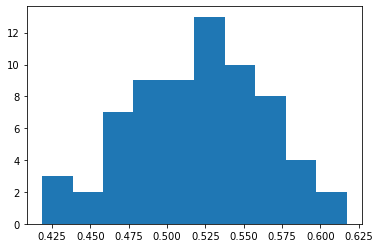

In [64]:
plt.hist(preds.squeeze().tolist()) 

In [65]:
trainEvalDf = pd.DataFrame(trainTups, columns=["fold", "batch", "BCEloss"]) 

In [66]:
#sns.lineplot(x="batch", y="f1", hue="fold", data=validDf) 

In [67]:
import seaborn as sns
#sns.lineplot(x="batch", y="BCEloss", hue="fold", data=trainEvalDf) 

In [69]:
MODEL_STEM = "basicModel" 
OUT_STEM = "/shared/3/projects/newsDiffusion/models/IRTModelling/savedModels/outletEmbeddingsModel/" + MODEL_STEM 

#save data related to best model 
torch.save(model.state_dict(), OUT_STEM + ".pth") 
artifact = wandb.Artifact(MODEL_STEM, type="model") 
artifact.add_file(OUT_STEM + ".pth") 
run.log_artifact(artifact)

#save embeddings 
finalOutletEmbeddings = np.array(model.embeddings.weight.data.cpu())

with open(OUT_STEM + "Embeddings.arr", "wb") as embedsFile:  
    pickle.dump(finalOutletEmbeddings, embedsFile)

artifact = wandb.Artifact(MODEL_STEM + "Embeddings", type="embeddings") 
artifact.add_file(OUT_STEM + "Embeddings.arr") 
run.log_artifact(artifact)

#save dict mapping embeddings to outlet names
with open(OUT_STEM + "EmbeddingsDict.dict", "wb") as dictFile: 
    pickle.dump(outletDict, dictFile)

artifact = wandb.Artifact(MODEL_STEM + "EmbeddingsDict", type="dict") 
artifact.add_file(OUT_STEM + "EmbeddingsDict.dict") 
run.log_artifact(artifact)

run.finish()

trainLoss,█▁▃▂▃▃▂
validF1,▁▅▇██▇▇
trainLoss,0.69806
validF1,0.58697
